Annalisa Donat, Data Scientist<br>
Connect with me on <a href="https://www.linkedin.com/in/annalisa-donat-20476a104/" target="_blank">LinkedIn</a>


&nbsp;

**Predicting Sales from Advertising Budget**

**Overview:** In this analysis I will show how a client could **increase sales by 34.6%.**

**Contents**

    1  Load and Check Data
    2  Explore Dataset
        2.1  Create Training and Test Sets
        2.2  Define Visualization Functions
        2.3  Explore Training Data
    3  Task 1: Predict Sales from Advertising Budget
        3.1  Define Visualization Functions
        3.2  Linear Regression
        3.3  RANSAC Linear Regression
        3.4  Decision Tree Regressor
        3.5  ADABoost Regression
    4  Task 2: Recommend New Budget Allocations
        4.1  Description of Task and Market Constraints
            4.1.1  Market Constraints
        4.2  Find Best Budget Allocation by Total Budget
        4.3  Visualize Recommendations
        4.4  Describe Projected Increase in Sales
        4.5  Results

Import libraries:

In [2]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Load and Check Data

**Dataset:** 
Sales of a product in 200 different markets, together with advertising budgets in each of these markets for different media channels: <code>TV</code>, <code>radio</code> and <code>newspaper</code>. The <code>sales</code> are in thousands of units and the budget is in thousands of dollars.

**Tasks:**
1. Predict sales from advertising budget.
2. Suggest improved advertising budgets for similar campaign.

Load the data into a pandas DataFrame:

In [4]:
df = pd.read_csv("../Predicting Sales from Advertising Budget/Advertising.csv")

View the data:

In [5]:
print("Dataset contains %d rows and %d columns" % df.shape)

Dataset contains 200 rows and 5 columns


In [6]:
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


The "Unnamed: 0" is unnecessary, remove it:

In [7]:
df = df.drop(columns="Unnamed: 0")

Check for null values:

In [8]:
df.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Create a new column in the DataFrame called <code>total_budget</code>. Although this column will not be included in any sales-prediction models (which would lead to overfitting), it will be useful for visualizing and understanding the dataset. 

In [9]:
df["total_budget"] = df[["TV", "radio", "newspaper"]].sum(axis=1)

(Optional) Re-order columns for display purposes:

In [10]:
df = df[["TV", "radio", "newspaper", "total_budget", "sales"]]

As a sanity check, use the .describe() function to make sure the data does not contain any obvious errors (ex. a negative advertising budget):

In [11]:
df.describe().round(1)

,TV,radio,newspaper,total_budget,sales
count,200.0,200.0,200.0,200.0,200.0
mean,147.0,23.3,30.6,200.9,14.0
std,85.9,14.8,21.8,93.0,5.2
min,0.7,0.0,0.3,11.7,1.6
25%,74.4,10.0,12.8,123.6,10.4
50%,149.8,22.9,25.8,207.4,12.9
75%,218.8,36.5,45.1,281.1,17.4
max,296.4,49.6,114.0,433.6,27.0


There are no obvious issues.

# Explore Dataset

## Create Training and Test Sets

Creating a test set allows us to evaluate the variance of our model. Variance is the extent to which patterns detected in the training data can be generalized to unseen data (such as the test set). 

In [12]:
train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=1)

In [13]:
predictor_vars = ["TV", "radio", "newspaper"]

In [14]:
train_X = train_df[predictor_vars].values
train_y = train_df["sales"].values
test_X = test_df[predictor_vars].values
test_y = test_df["sales"].values

## Define Visualization Functions

In [15]:
def calculate_pvalues(dfr, method_func=pearsonr):
    """
    dfr : dataframe
    method_func : function (NOT A STRING)
        - either pearsonr or spearmanr from scipy.stats
    """
    dfcols = pd.DataFrame(columns=dfr.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in dfr.columns:
        for c in dfr.columns:
            pvalues[r][c] = round(method_func(dfr[r], dfr[c])[1], 2)
    return pvalues

In [16]:
def get_p_val_mask(dfr, method_func=pearsonr, p_val_cutoff=0.1):
    """
    dfr : dataframe
    method_func : function (NOT A STRING)
        - either pearsonr or spearmanr from scipy.stats
    p_val_cutoff : float
        - 0 < p_val_cutoff < 1
    """
    p_vals_mtrx = calculate_pvalues(dfr, method_func=method_func)
    for c in list(p_vals_mtrx):
        p_vals_mtrx[c] = p_vals_mtrx[c].apply(
            lambda x: 0 if x >= 0.1 else 1)
    return p_vals_mtrx

## Explore Training Data

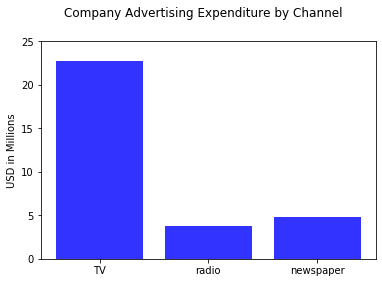

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(predictor_vars, 
       train_df[predictor_vars].sum(axis=0)/1000, alpha=.8, color="blue")
# note that sales were originally in thousands, then divided by 1000:
ax.set_ylabel("USD in Millions")   
ax.set_yticks(np.arange(0, 30, 5))
fig.suptitle("Company Advertising Expenditure by Channel", y=1)
plt.show()

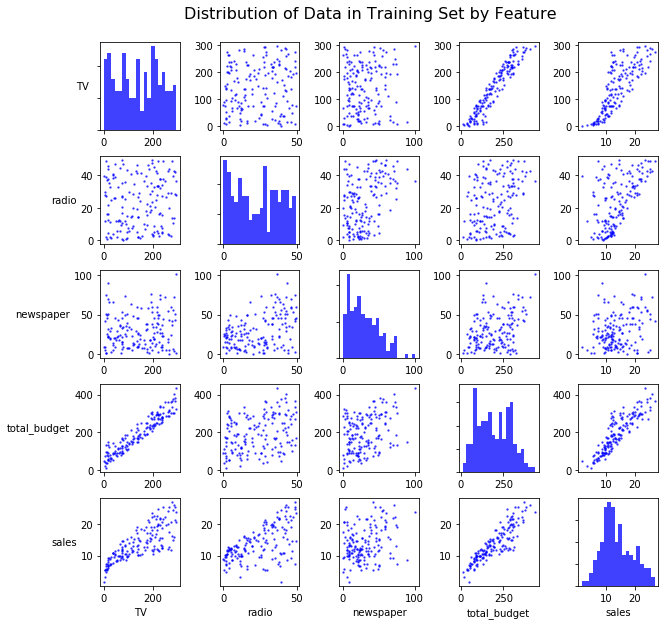

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    
# plot data:
for j in range(5):
    for i in range(5):
        if i==j:
            axes[j][i].hist(x=train_df[list(train_df)[i]], bins=20,
                            color="blue", alpha=0.75)
            axes[j][i].set_yticklabels([])
        else:
            axes[j][i].scatter(x=train_df[list(train_df)[i]], 
                               y=train_df[list(train_df)[j]], 
                               color="blue", s=2, alpha=0.6)
                    
# formatting: label x-axis of bottom row and y-axis of left column
for k in range(5):
    label_text = list(train_df)[k].replace(" ", "\n")
    axes[4][k].set_xlabel(label_text)
    axes[k][0].set_ylabel(label_text, rotation=0, ha="right", va="center")

fig.suptitle("Distribution of Data in Training Set by Feature", 
             fontsize=16, y=.93)

plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()

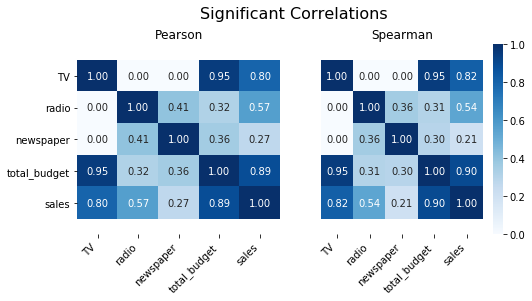

In [19]:
fig, axes = plt.subplots(figsize=(8, 3.5), ncols=2)
sns.heatmap(train_df.corr(
    method="pearson").round(2)*get_p_val_mask(train_df, pearsonr), 
            cmap="Blues", ax=axes[0], center=.5, 
            annot=True, fmt=".2f", cbar=False)
axes[0].set_title("Pearson")

sns.heatmap(train_df.corr(
    method="spearman").round(2)*get_p_val_mask(train_df, spearmanr), 
            cmap="Blues", ax=axes[1], center=.5, 
            annot=True, fmt=".2f")
axes[1].set_title("Spearman")

axes[1].set_yticklabels([])
axes[1].set_yticks([])


for my_ax in axes:
    bottom, top = my_ax.get_ylim()
    my_ax.set_ylim(bottom + 0.5, top - 0.5)
    my_ax.set_xticklabels(my_ax.get_xticklabels(), 
                          rotation=45, ha="right")

fig.suptitle("Significant Correlations", y=1.03, fontsize=16)

plt.show()

In [20]:
from sklearn.feature_selection import f_regression

In [21]:
from sklearn.preprocessing import quantile_transform

In [22]:
f_scores = f_regression(train_X, train_y)

In [23]:
f_scores

(array([280.14341559,  74.61801398,  12.86345116]),
 array([8.01212052e-37, 5.92023347e-15, 4.46264222e-04]))

<BarContainer object of 3 artists>

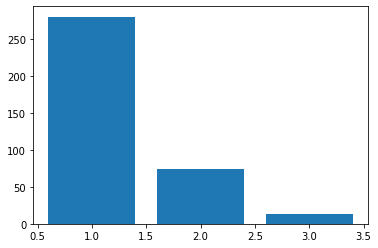

In [24]:
plt.bar(np.arange(1, 4), f_scores[0])

In [25]:
f_scores_uniform = f_regression(quantile_transform(
    train_X, n_quantiles=100,
    output_distribution="uniform", copy=True), train_y)

In [26]:
f_scores_uniform

(array([276.40193959,  74.96202804,   9.96785897]),
 array([1.58133060e-36, 5.25997796e-15, 1.90833703e-03]))

**OBSERVATIONS**

<u>Variable Distribution:</u>
1. <code>TV</code> (tv advertising expenditure) does **not** have a **normal** distribution, but is **not** particularly **skewed** in either direction.
    1. distribution appears to be multimodal, perhaps following a sinusoidal distribution.
2. <code>radio</code> (radio advertising expenditure) does **not** have a **normal** distribution, and is **very slightly skewed left**.
3. <code>newspaper</code> (newspaper advertising expenditure) does **not** have a **normal** distribution, and is **skewed left**.
4. <code>sales</code> has a relatively **normal** distribution, although it may be very slightly skewed left.
    1. given that there are only 200 observations in the dataset, there is no reason to assume that this extremely slight distortion is not trivial.
<br>

*Implication: It is necessary to be mindful of the influence of outliers, especially in <code>newspaper</code> advertising budget, which has a skewed distribution.*

&nbsp;

<u>Relationships Between Predictor Variables:</u>
1. There is **no relationship** (positive or negative) between <code>TV</code> and <code>radio</code>.
2. There is **no relationship** (positive or negative) between <code>TV</code> and  and <code>newspaper</code>.
3. There appears to be a **very small positive relationship** between <code>radio</code> and <code>newspaper</code>.
<br>

*Implication: As the relationship between these variables is minimal, a Principal Component Analysis is not necessary.*

&nbsp;

<u>Observations about Total Budget:</u>
1. The company appears to spend roughly 5 to 10 USD in advertising per unit sold.
    1. price per unit = 5 to 10 USD (advertising) + additional costs + profit per unit
2. <code>TV</code> generally accounts for the largest portion of <code>total_budget</code>.
3. There is a **positive linear relationship** between <code>total_budget</code> and <code>sales</code>. 
    1. The **standard deviation** of <code>sales</code> **increases** as the value of <code>total_budget</code> increases.
4. As <code>total_budget</code> is a sum of three other variables, using <code>total_budget</code> in the analysis would lead to overfitting. Thus, <code>total_budget</code> **should be dropped from the dataset**.


<u>Relationships Between Predictor Variables and Sales:</u>
1. There is a **positive non-linear relationship** between <code>TV</code> and <code>sales</code>.
    1. This effect size is much stronger for markets with very low <code>TV</code> advertising budgets, which is consistent with the Theory of Diminishing Returns.
    2. The **standard deviation** of <code>sales</code> **increases** as the value of <code>TV</code> increases.
2. There appears to be a **positive linear relationship** between <code>radio</code> and <code>sales</code>. 
    1. It may be easier to predict the maximum <code>sales</code> given the <code>radio</code> value than to predict the minimum <code>sales</code>.
3. There appears to be a **very small positive relationship** between <code>newspaper</code> and <code>sales</code>.
4. Increases in <code>radio</code> may correspond to a larger increase in <code>sales</code> than would increases in <code>TV</code>.

*Implication: A linear regression may not be the best method for analyzing this data, as it could fail to capture the non-linear relationship between <code>TV</code> (which accounts for the largest portion of the overall budget) and <code>sales</code>.*

# Task 1: Predict Sales from Advertising Budget

## Define Visualization Functions

In [27]:
color_explanation = "Darker purple dots correspond to higher values for "\
"the other two budget channels."

In [28]:
def plot_model_and_residuals(model, thin_trendline=False, 
                             show_ma=False, ma_window=14, model_name=None):
    """ Fits three versions of the model - one for each feature - and 
    plots each fitted model and the residuals.
    
    Parameters
    ------------
    model: sklearn Estimator
    thin_trendline: bool
        - highly recommended that thin_trendline == True if show_ma == True
    show_ma: bool
        - whether to show the moving average in addition to the trendline
    ma_window : int
        - window used to calculate the moving average
        - ma_window > 0
        - ignored if show_ma == False
    model_name: str or None
    
    Returns
    ------------
    None (but displays matplotlib plot)
    """
    plt.rcdefaults()
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    for i in range(3):
        model = model.fit(train_X[:, i].reshape(-1, 1), train_y)
        x_all = np.linspace(train_X[:, i].min()-10, 
                            train_X[:, i].max()+10, 100)
        y_all_pred = model.predict(x_all.reshape(-1, 1))
        other_X_cols = [j for j in range(3) if j!=i]
        sns.scatterplot(train_X[:, i], train_y, 
                        hue=train_X[:, other_X_cols].sum(axis=1),
                        alpha=.7, ax=axes[0][i])
        if thin_trendline:
            axes[0][i].plot(x_all, y_all_pred, color="black", 
                            linewidth=1, alpha=0.6)
        else:
            axes[0][i].plot(x_all, y_all_pred, color="black")
            
        if show_ma:
            ma_y_pred = pd.Series(y_all_pred).rolling(
                ma_window, min_periods=1).mean().values
            axes[0][i].plot(x_all, ma_y_pred, color="black")
        
        axes[0][i].set_title(predictor_vars[i])
        axes[0][i].set_xlabel(predictor_vars[i] + " budget")
        axes[0][i].set_ylabel("Sales")
        axes[0][i].legend_.remove()

        pred_y = model.predict(train_X[:, i].reshape(-1, 1)).copy()
        sns.scatterplot(train_y, train_y-pred_y, 
                        hue=train_X[:, other_X_cols].sum(axis=1),
                        ax=axes[1][i], alpha=0.6)
        axes[1][i].axhline(color="black", linewidth=1)
        axes[1][i].set_xlabel("Sales")
        axes[1][i].set_ylabel("Residuals")
        axes[1][i].set_title(predictor_vars[i])
        axes[1][i].legend_.remove()
    
    if model_name:
        fig.suptitle(model_name + ": Univariate Fit and Residuals", 
                     fontsize=14)
    else:
        fig.suptitle("Univariate Fit and Residuals", fontsize=14)
    
    plt.figtext(0.5, 0.01, color_explanation, horizontalalignment='center') 
    plt.subplots_adjust(hspace=.4, wspace=.4)
    plt.show()

In [29]:
def evaluate_model(model, X_train=train_X, y_train=train_y,
                   X_test=test_X, y_test=test_y):
    model = model.fit(X_train, y_train)
    print("Training Set Score: ",
          model.score(X_train, y_train).round(3))
    print("Test Set Score:     ",
          model.score(X_test, y_test).round(3))

In [30]:
def summarize_gs(gs):
    """Prints best test (validation) score of a fitted GridSearchCV object
    Parameters
    ------------
    gs : fitted GridSearchCV object
    
    Returns
    -------
    None
    """
    if len(list(gs.best_params_.keys())) > 0:
        print("Best Parameters:", gs.best_params_)
    gs_std_test_score = gs.cv_results_["std_test_score"][gs.best_index_]
    print("Best Score: %.3f +/- %.3f" % (gs.best_score_, gs_std_test_score))

In [31]:
from sklearn.model_selection import learning_curve

In [32]:
def plot_learning_curves(estimator_var, X_train, y_train, ax, title="", 
                         scoring_method="r2"):
    """plots the learning curves for estimator_var
    Parameters
    ------------
    estimator_var : classifier object
    X_train : array
    y_train : array
    ax : matplotlib axis
    title : str
    scoring_method : str
        ex. "recall"
        - should be all lowercase
    
    Returns
    ------------
    learning_curve_graph : graph on matplotlib axis
    """
    train_sizes, train_scores_by_size, test_scores_by_size = learning_curve(
        estimator=estimator_var, X=X_train, y=y_train, scoring=scoring_method,
        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

    train_means = np.mean(train_scores_by_size, axis=1)
    train_stds = np.std(train_scores_by_size, axis=1)
    test_means = np.mean(test_scores_by_size, axis=1)
    test_stds = np.std(test_scores_by_size, axis=1)

    learning_curve_graph = ax.plot(
        train_sizes, train_means, color="red", marker="o",
        markersize=5, label="training " + scoring_method)

    ax.fill_between(
        train_sizes, train_means + train_stds, train_means - train_stds,
        alpha=0.15, color="red")

    ax.plot(train_sizes, test_means, 
            color="green", linestyle="--",
            marker="s", markersize=5, label="validation " + scoring_method)

    ax.fill_between(
        train_sizes, test_means + test_stds, test_means - test_stds,
        alpha=0.15, color="green")

    ax.set_title(title)
    ax.set_xlabel("Size of Training Sets")
    ax.set_ylabel(scoring_method.capitalize())
    ax.legend(loc="lower right")
    ax.set_ylim(0, 1.02)
    return learning_curve_graph


## Linear Regression

As previously discussed, I do not believe that a linear regression is the best approach given the non-linear relationship between TV and sales. However, a linear regression will serve as a good baseline for comparing other models. I hypothesize that a linear regression will still capture general trends in the data.

To further illustrate the shortcomings of a linear regression, the plots below show a univariate regression fitted to each feature of the data.

In [33]:
sc = StandardScaler()
lnr = LinearRegression()

In [34]:
from sklearn.feature_selection import SelectKBest

In [35]:
skb = SelectKBest()

In [36]:
def extract_k_columns(X, k=3):
    """
    X: numpy array of floats
    k: 1 2 or 3
    """
    return X[:, :k]

In [37]:
from sklearn.preprocessing import FunctionTransformer

In [38]:
ekc = FunctionTransformer(extract_k_columns)

In [39]:
ekc_ks = [{"k": 1}, {"k": 2}, {"k": 3}]

In [40]:
gs_params = {"scoring": "r2", "return_train_score": True, 
             "cv": 5, "n_jobs": -1, "iid": True}

In [41]:
ekc_params = {"ekc__kw_args": ekc_ks}

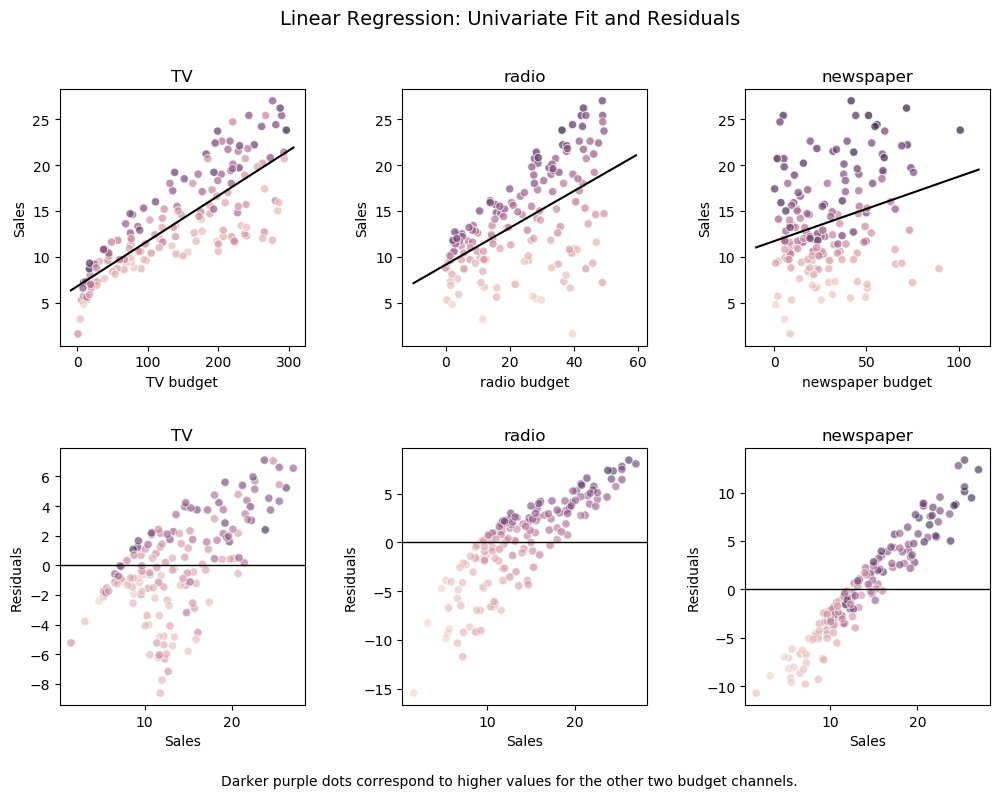

In [42]:
pipe_lnr = Pipeline([("sc", sc), ("lnr", lnr)])
plot_model_and_residuals(pipe_lnr, model_name="Linear Regression")

There is a relationship between the target variables and the residuals, indicating that a univariate linear regression is not appropriate for any of the three predictor variables.

Fit a Multivariate Linear Regression:

In [43]:
pipe_ln_reg = Pipeline([("sc", sc), ("ekc", ekc), ("lnr", lnr)])
gs_lnr = GridSearchCV(pipe_ln_reg, {"ekc__kw_args": ekc_ks}, **gs_params)
gs_lnr = gs_lnr.fit(train_X, train_y)
summarize_gs(gs_lnr)

Best Parameters: {'ekc__kw_args': {'k': 2}}
Best Score: 0.887 +/- 0.033


In [44]:
pipe_ln_reg = pipe_ln_reg.set_params(**gs_lnr.best_params_)
evaluate_model(pipe_ln_reg)

Training Set Score:  0.896
Test Set Score:      0.895


## RANSAC Linear Regression

As previously discussed, newspaper and radio both have skewed distributions, and thus the influence of outliers may explain the poor fit of the linear regression. RANSAC reduces the influence of outliers.

In [45]:
ransac = RANSACRegressor(
    LinearRegression(), max_trials=100, min_samples=50, 
    loss='absolute_loss', residual_threshold=5.0, random_state=1)

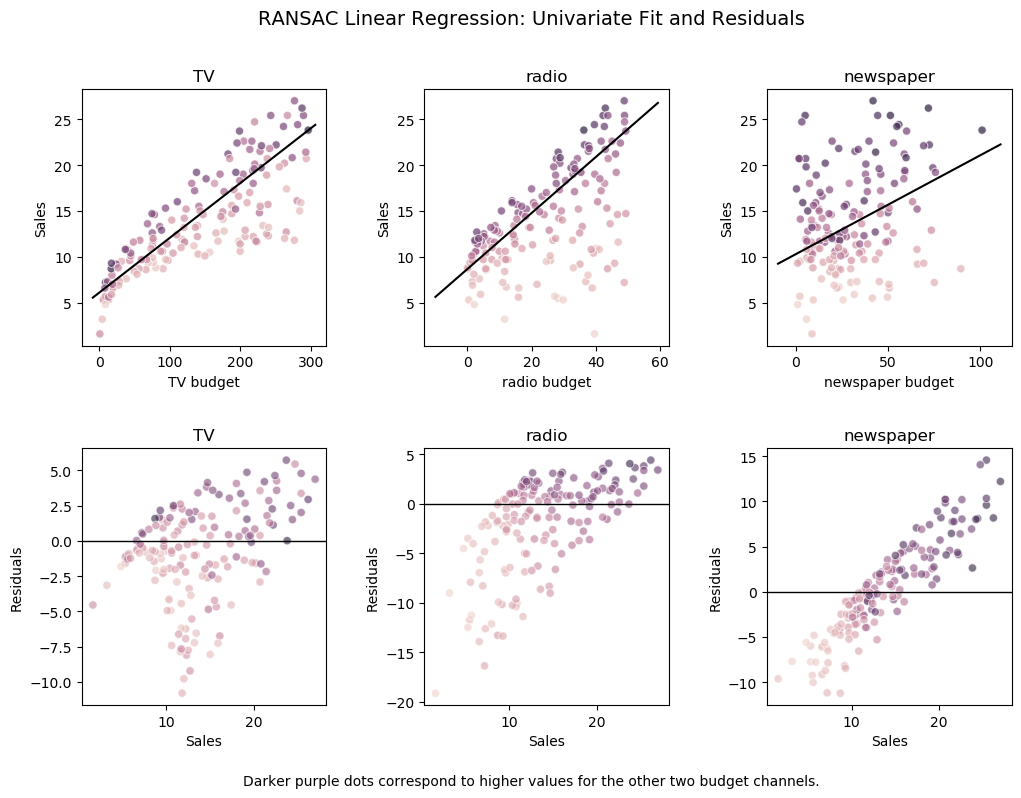

In [46]:
pipe_lnr_ransac = Pipeline([("sc", sc), ("ransac", ransac)])
plot_model_and_residuals(pipe_lnr_ransac, 
                         model_name="RANSAC Linear Regression")

Univariate linear regressions seem to be somewhat improved with RANSAC, although there is still a strong relationship between the target data and the residuals.

Fit multivariate RANSAC linear regression:

In [47]:
pipe_lnr_ransac = Pipeline([("sc", sc), ("ekc", ekc), ("ransac", ransac)])

In [48]:
gs_lnr_ransac = GridSearchCV(pipe_lnr_ransac, ekc_params, **gs_params)
gs_lnr_ransac = gs_lnr_ransac.fit(train_X, train_y)
summarize_gs(gs_lnr_ransac)

Best Parameters: {'ekc__kw_args': {'k': 2}}
Best Score: 0.887 +/- 0.035


In [ ]:
################################################################################

In [49]:
pipe_lnr_ransac = pipe_lnr_ransac.set_params(**gs_lnr_ransac.best_params_)
evaluate_model(pipe_lnr_ransac)

Training Set Score:  0.895
Test Set Score:      0.902


The improvement in the test set score is minimal.

## Decision Tree Regressor

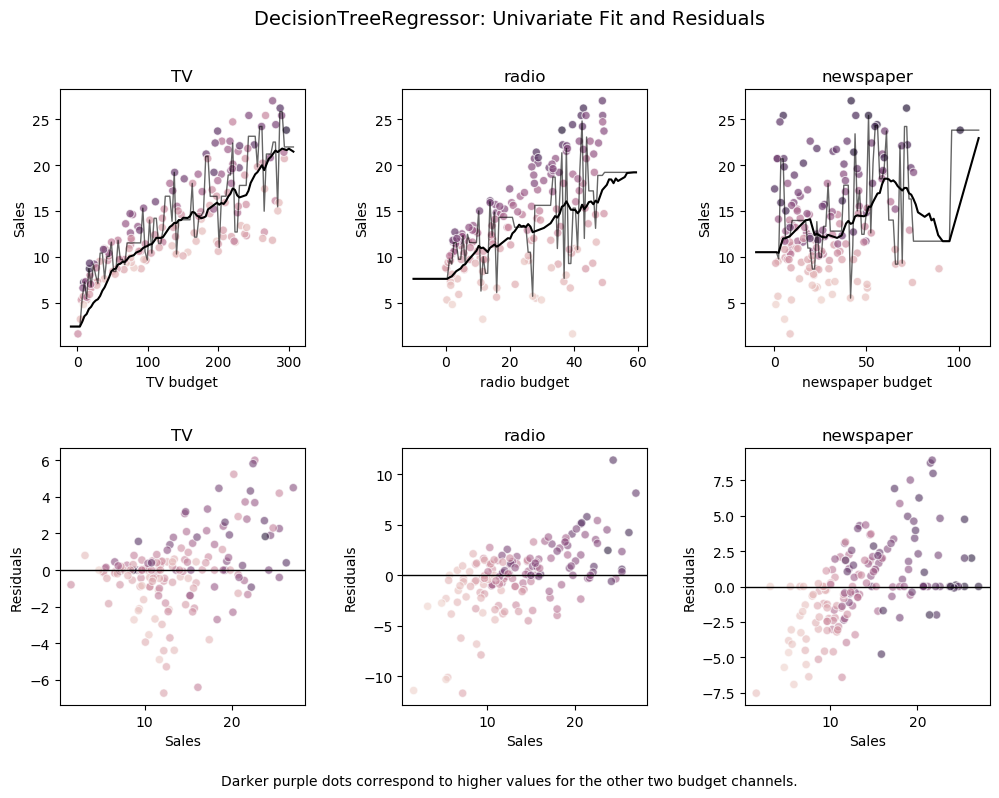

In [50]:
dt_reg = DecisionTreeRegressor(max_depth=8, min_samples_split=4)
plot_model_and_residuals(dt_reg, thin_trendline=True, show_ma=True,
                         model_name="DecisionTreeRegressor")

The decision tree regressor would be a better fit **IF** overfitting can be prevented.

In [56]:
dtr_params = {
    "ekc__kw_args": ekc_ks,
    "dt__max_depth": [6, 8, 10, 15, 50], 
    "dt__min_samples_split": [2, 3, 4, 5, 20]}

In [54]:
dt = DecisionTreeRegressor(random_state=1)

In [57]:
pipe_dt = Pipeline([("ekc", ekc), ("dt", dt)])
gs_dtr = GridSearchCV(pipe_dt, dtr_params, **gs_params)
gs_dtr = gs_dtr.fit(train_X, train_y)
summarize_gs(gs_dtr)

Best Parameters: {'dt__max_depth': 10, 'dt__min_samples_split': 4, 'ekc__kw_args': {'k': 2}}
Best Score: 0.955 +/- 0.014


In [59]:
pipe_dt = pipe_dt.set_params(**gs_dtr.best_params_)
evaluate_model(pipe_dt)

Training Set Score:  0.997
Test Set Score:      0.972


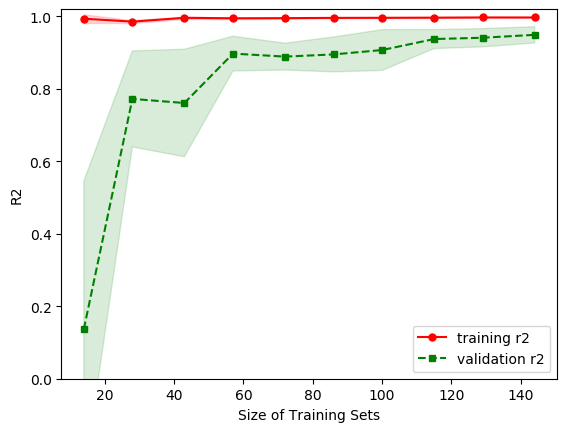

In [102]:
fig, my_ax = plt.subplots()
plot_learning_curves(dtr2, train_X, train_y, my_ax)


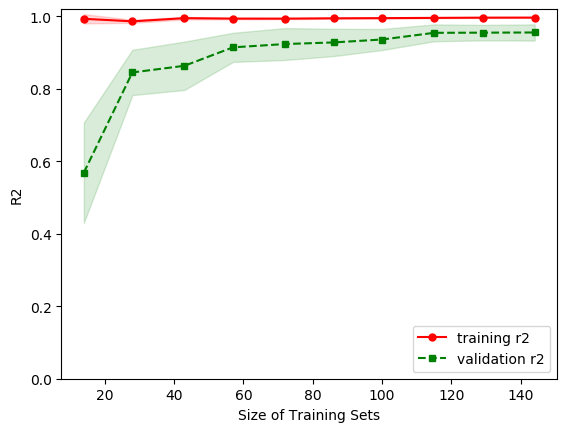

In [103]:
fig, my_ax = plt.subplots()
plot_learning_curves(dtr2, train_X[:, :2], train_y, my_ax)

Overfitting was prevented, and this is by far the best method so far.

## ADABoost Regression

The Decision Tree Regression worked quite well, but the model could likely be further improved by using an ADABoost Regressor built on the Decision Tree Regressor.

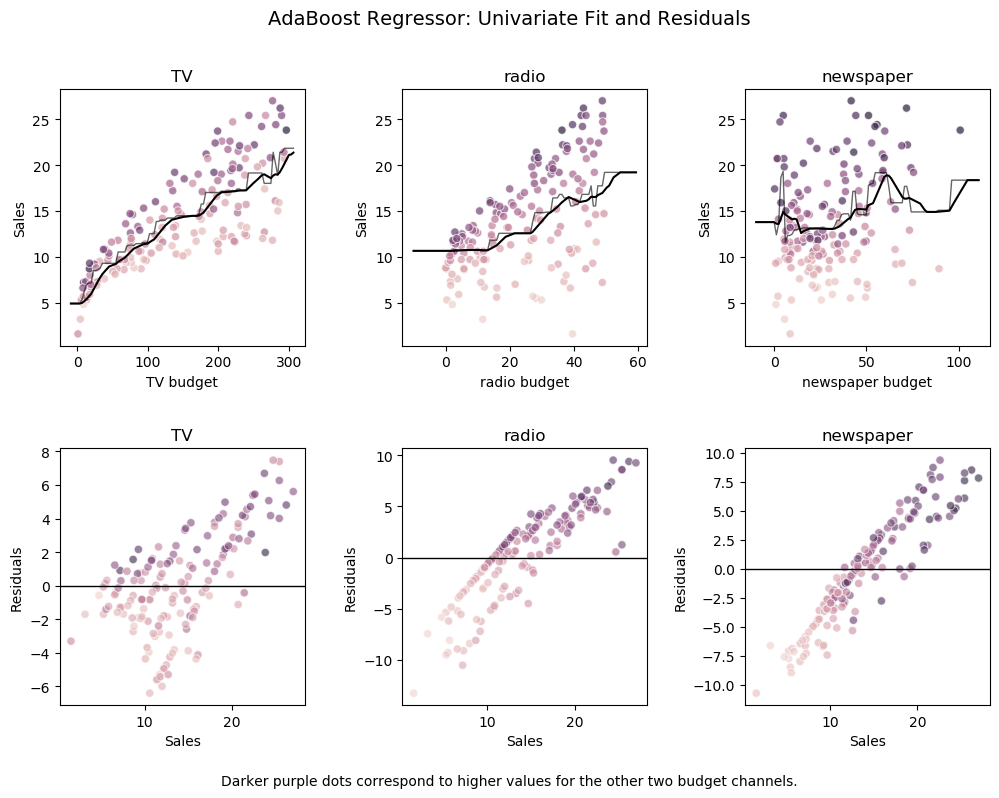

In [60]:
adabr = AdaBoostRegressor(random_state=1)
plot_model_and_residuals(adabr, thin_trendline=True, 
                         show_ma=True, ma_window=8,
                         model_name="AdaBoost Regressor")

In [61]:
pipe_adabr = Pipeline([("ekc", ekc), ("adabr", adabr)])
gs_adabr = GridSearchCV(pipe_adabr, ekc_params, **gs_params)
gs_adabr = gs_adabr.fit(train_X, train_y)
summarize_gs(gs_adabr)

Best Parameters: {'ekc__kw_args': {'k': 2}}
Best Score: 0.959 +/- 0.017


In [62]:
pipe_adabr = pipe_adabr.set_params(**gs_adabr.best_params_)
evaluate_model(pipe_adabr)

Training Set Score:  0.979
Test Set Score:      0.97


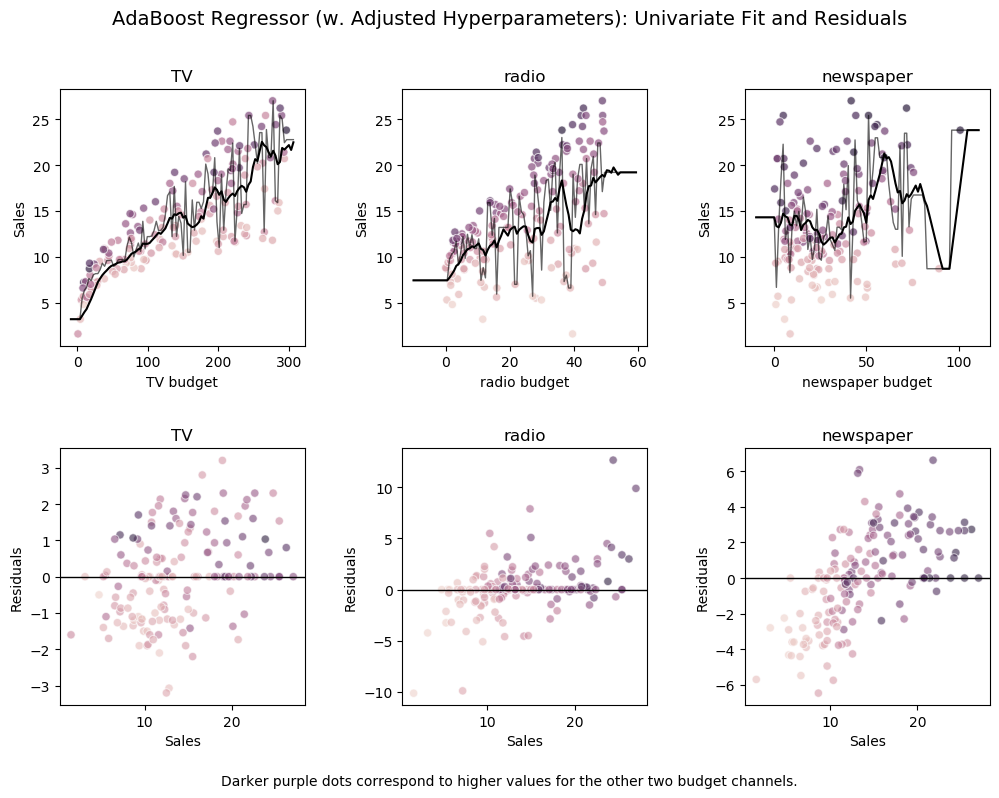

In [66]:
plot_model_and_residuals(
    pipe_adabr_v2, thin_trendline=True,
    show_ma=True, ma_window=8,
    model_name="AdaBoost Regressor (w. Adjusted Hyperparameters)")

The AdaBoost performed better on the test set. The performance may be further improved by using parameters Decision Tree Regressors found through the grid search.

In [86]:
adabr_v2 = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(
        max_depth=10, min_samples_split=4), random_state=1)

In [97]:
pipe_adabr_v2 = Pipeline([("ekc", ekc), ("adabr", adabr_v2)])
gs_adabr_v2 = GridSearchCV(pipe_adabr_v2, ekc_params, **gs_params)
gs_adabr_v2 = gs_adabr_v2.fit(train_X, train_y)
summarize_gs(gs_adabr_v2)

Best Parameters: {'ekc__kw_args': {'k': 2}}
Best Score: 0.972 +/- 0.013


In [98]:
pipe_adabr_v2 = pipe_adabr_v2.set_params(**gs_adabr_v2.best_params_)
evaluate_model(pipe_adabr_v2)

Training Set Score:  0.999
Test Set Score:      0.981


In [104]:
adabr_v3 = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(
        max_depth=10, min_samples_split=4), 
    loss="exponential", random_state=1)

In [105]:
pipe_adabr_v3 = Pipeline([("ekc", ekc), ("adabr", adabr_v3)])
gs_adabr_v3 = GridSearchCV(pipe_adabr_v3, ekc_params, **gs_params)
gs_adabr_v3 = gs_adabr_v3.fit(train_X, train_y)
summarize_gs(gs_adabr_v3)

Best Parameters: {'ekc__kw_args': {'k': 2}}
Best Score: 0.971 +/- 0.014


In [106]:
pipe_adabr_v3 = pipe_adabr_v3.set_params(**gs_adabr_v3.best_params_)
evaluate_model(pipe_adabr_v3)

Training Set Score:  1.0
Test Set Score:      0.985


In [108]:
adabr_v4 = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(
        max_depth=10, min_samples_split=4), 
    loss="square", random_state=1)

In [112]:
ekc_params2 = {"ekc__kw_args": [{"k": 1}, {"k": 2}]}

In [114]:
ekc_params

{'ekc__kw_args': [{'k': 1}, {'k': 2}, {'k': 3}]}

In [115]:
ekc_params2

{'ekc__kw_args': [{'k': 1}, {'k': 2}]}

In [116]:
pipe_adabr_v4 = Pipeline([("ekc", ekc), ("adabr", adabr_v4)])
gs_adabr_v4 = GridSearchCV(
    pipe_adabr_v4, 
    ekc_params2, **gs_params)
gs_adabr_v4 = gs_adabr_v4.fit(train_X, train_y)
summarize_gs(gs_adabr_v4)

Best Parameters: {'ekc__kw_args': {'k': 2}}
Best Score: 0.971 +/- 0.013


In [117]:
pipe_adabr_v4 = pipe_adabr_v4.set_params(**gs_adabr_v4.best_params_)
evaluate_model(pipe_adabr_v4)

Training Set Score:  0.998
Test Set Score:      0.985


Wow! This model has a test set r2 score 0.082 higher than the linear regression's test set score (r2 = 0.893), confirming my hypothesis that a linear regression would not be the best way to model the dataset.

## Interpretation of Model

Visualize the increase in sales resulting from increasing each portion of an advertising budget:

In [42]:
df[["TV", "radio", "newspaper"]].describe().round(1).iloc[3:]

,TV,radio,newspaper
min,0.7,0.0,0.3
25%,74.4,10.0,12.8
50%,149.8,22.9,25.8
75%,218.8,36.5,45.1
max,296.4,49.6,114.0


In [43]:
np.set_printoptions(suppress=True)

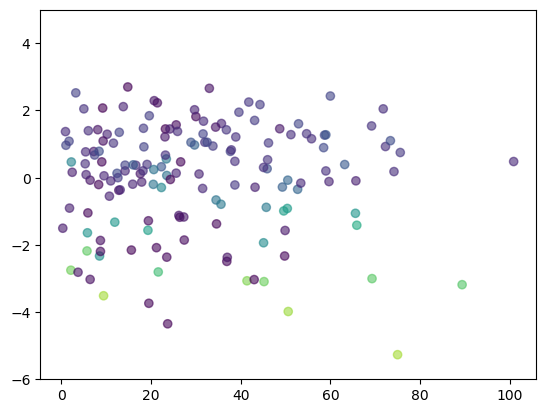

In [105]:
pipe_lnr_ransac2 = Pipeline([("sc", sc), ("ransac", ransac)])
pipe_lnr_ransac2 = pipe_lnr_ransac2.fit(train_X[:, :2], train_y)
temp_ypred = pipe_lnr_ransac2.predict(train_X[:, :2])
fig, ax = plt.subplots()
ax.scatter(train_X[:, 2], y=train_y-temp_ypred, 
           c=train_X[:, 1]*100/(train_X[:, :2].sum(axis=1)), alpha=0.6)
#ax.axhline(color="black")
ax.set_ylim(-6, 5)
# purple -> lower values
plt.show()

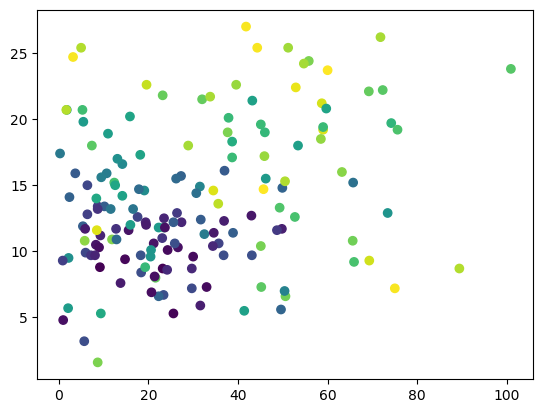

In [85]:
plt.scatter(x="newspaper", y="sales", c="radio", data=train_df)
plt.show()

In [95]:
def qrtile_array(var, q):
    q_array = np.ones(100)*df[var].quantile(q)
    return q_array


def full_array(var):
    f_array = np.linspace(df[var].min(), df[var].max(), 100)
    return f_array


def get_synthetic_data(full, tv_q=0.5, radio_q=0.5, newspaper_q=0.5):
    """
    full: str
    - "TV", "radio", or "newspaper"
    """
    a = qrtile_array("TV", tv_q)
    b = qrtile_array("radio", radio_q)
    c = qrtile_array("newspaper", newspaper_q)
    if full == "TV":
        a = full_array("TV")
    elif full == "radio":
        b = full_array("radio")
    else:
        c = full_array("newspaper")
    synthetic_array = np.vstack((a, b, c)).transpose()
    return synthetic_array
    

In [ ]:
tv_full = full_array("TV")


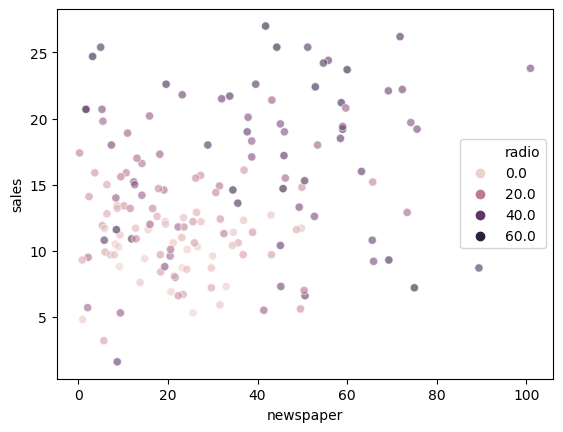

In [86]:
sns.scatterplot(x="newspaper", y="sales", 
                        hue="radio", data=train_df, alpha=0.6)

In [ ]:
tv_l_l = np.vstack((full_array("TV"), 
                    qrtile_array("radio", .25),
                    qrtile_array("newspaper", .25))).transpose()

In [ ]:
tv_full = np.linspace(df["TV"].min(), df["TV"].max(), 100).shape

In [60]:
tv_l_l = np.vstack((np.linspace(df["TV"].min(), df["TV"].max(), 100), 
                    np.ones(100)*df["radio"].quantile(.25),
                    np.ones(100)*df["newspaper"].quantile(.25)
                   )).transpose()

In [66]:
tv_h_h = np.vstack((np.linspace(df["TV"].min(), df["TV"].max(), 100), 
                    np.ones(100)*df["radio"].quantile(.75),
                    np.ones(100)*df["newspaper"].quantile(.75)
                   )).transpose()

In [69]:
tv_l_h = np.vstack((np.linspace(df["TV"].min(), df["TV"].max(), 100), 
                    np.ones(100)*df["radio"].quantile(.25),
                    np.ones(100)*df["newspaper"].quantile(.75)
                   )).transpose()

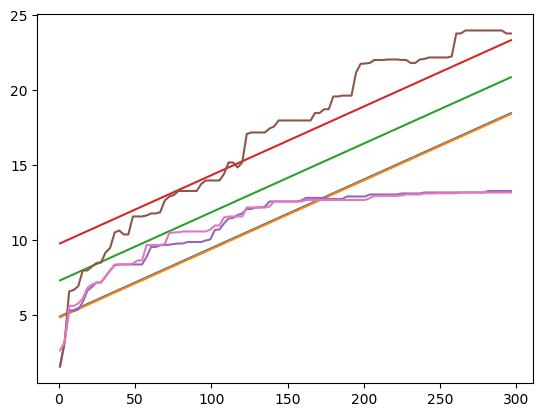

In [79]:
fig, ax = plt.subplots()
'''ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         pipe_ln_reg.predict(tv_l_l))'''

ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         pipe_lnr_ransac.predict(tv_l_l))
ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         pipe_lnr_ransac.predict(tv_l_h))
ax.plot(full_array("TV"), pipe_lnr_ransac.predict(
    get_synthetic_data("TV", radio_q=0.5, newspaper_q=0.25)))
ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         pipe_lnr_ransac.predict(tv_h_h))
'''ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         dtr.predict(tv_l_l))'''
ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         adabr_v2.predict(tv_l_l))
ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         adabr_v2.predict(tv_h_h))
ax.plot(np.linspace(df["TV"].min(), df["TV"].max(), 100), 
         adabr_v2.predict(tv_l_h))
plt.show()

In [108]:
tv_l_h.shape

(100, 3)

In [109]:
get_synthetic_data("TV").shape

(100, 3)

In [81]:
pct_dists.shape

(101, 3)

In [84]:
train_X

array([[ 13.1,   0.4,  25.6],
       [ 90.4,   0.3,  23.2],
       [ 18.7,  12.1,  23.4],
       [204.1,  32.9,  46. ],
       [  7.3,  28.1,  41.4],
       [147.3,  23.9,  19.1],
       [ 78.2,  46.8,  34.5],
       [228. ,  37.7,  32. ],
       [205. ,  45.1,  19.6],
       [229.5,  32.3,  74.2],
       [289.7,  42.3,  51.2],
       [123.1,  34.6,  12.4],
       [ 19.4,  16. ,  22.3],
       [182.6,  46.2,  58.7],
       [265.6,  20. ,   0.3],
       [165.6,  10. ,  17.6],
       [218.5,   5.4,  27.4],
       [ 25. ,  11. ,  29.7],
       [232.1,   8.6,   8.7],
       [ 43. ,  25.9,  20.5],
       [139.2,  14.3,  25.6],
       [139.3,  14.5,  10.2],
       [  5.4,  29.9,   9.4],
       [293.6,  27.7,   1.8],
       [281.4,  39.6,  55.8],
       [  8.7,  48.9,  75. ],
       [ 80.2,   0. ,   9.2],
       [137.9,  46.4,  59. ],
       [227.2,  15.8,  49.9],
       [ 31.5,  24.6,   2.2],
       [262.7,  28.8,  15.9],
       [213.5,  43. ,  33.8],
       [287.6,  43. ,  71.8],
       [ 1

In [83]:
pct_dists*50

array([[ 0. , 50. ,  0. ],
       [ 0.5, 49.5,  0. ],
       [ 1. , 49. ,  0. ],
       [ 1.5, 48.5,  0. ],
       [ 2. , 48. ,  0. ],
       [ 2.5, 47.5,  0. ],
       [ 3. , 47. ,  0. ],
       [ 3.5, 46.5,  0. ],
       [ 4. , 46. ,  0. ],
       [ 4.5, 45.5,  0. ],
       [ 5. , 45. ,  0. ],
       [ 5.5, 44.5,  0. ],
       [ 6. , 44. ,  0. ],
       [ 6.5, 43.5,  0. ],
       [ 7. , 43. ,  0. ],
       [ 7.5, 42.5,  0. ],
       [ 8. , 42. ,  0. ],
       [ 8.5, 41.5,  0. ],
       [ 9. , 41. ,  0. ],
       [ 9.5, 40.5,  0. ],
       [10. , 40. ,  0. ],
       [10.5, 39.5,  0. ],
       [11. , 39. ,  0. ],
       [11.5, 38.5,  0. ],
       [12. , 38. ,  0. ],
       [12.5, 37.5,  0. ],
       [13. , 37. ,  0. ],
       [13.5, 36.5,  0. ],
       [14. , 36. ,  0. ],
       [14.5, 35.5,  0. ],
       [15. , 35. ,  0. ],
       [15.5, 34.5,  0. ],
       [16. , 34. ,  0. ],
       [16.5, 33.5,  0. ],
       [17. , 33. ,  0. ],
       [17.5, 32.5,  0. ],
       [18. , 32. ,  0. ],
 

In [75]:
pcts = np.linspace(0, 1, 101)
pct_dists = np.vstack((pcts, np.ones_like(pcts) - pcts, np.zeros_like(pcts))
                     ).transpose()

In [125]:
np.linspace(0, 1, 1000 + 1)


array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [123]:
def get_pct_dists(n=100):
    pcts = np.linspace(0, 1, n + 1)
    pct_dists = np.vstack(
        (pcts, np.ones_like(pcts) - pcts, np.zeros_like(pcts))
                         ).transpose()
    return pct_dists

In [80]:
train_X.shape

(160, 3)

In [89]:
pipe_adabr_v2.predict(train_X)

array([ 5.3       ,  8.76666667,  6.83333333, 19.        ,  5.5       ,
       14.7       , 14.6       , 21.85      , 22.46666667, 19.73333333,
       25.4       , 15.2       ,  6.8       , 21.2       , 17.4       ,
       12.6       , 12.06666667,  7.2       , 13.2       ,  9.85      ,
       12.2       , 13.33333333,  5.3       , 20.7       , 24.4       ,
        7.2       ,  8.8       , 19.2       , 15.        ,  9.5       ,
       20.2       , 21.7       , 25.93333333,  7.2       ,  8.        ,
       15.9       ,  9.1       ,  9.23333333, 22.2       , 15.5       ,
       15.6       , 11.33333333, 12.2       , 11.6       ,  9.9       ,
        9.7       , 11.3       ,  5.5       , 17.3       , 14.9       ,
       17.46666667, 25.4       , 13.3       , 10.45      , 19.        ,
       14.83333333,  7.6       , 12.8       , 10.8       , 11.7       ,
        8.7       , 12.2       ,  7.25      , 16.6       ,  9.3       ,
       18.3       , 15.2       , 15.9       , 11.8       , 14.1 

In [82]:
pipe_adabr_v2.predict(pct_dists*50)

ValueError: Number of features of the model must match the input. Model n_features is 1 and input n_features is 2 

In [91]:
train_df["total_budget"].min()

11.7

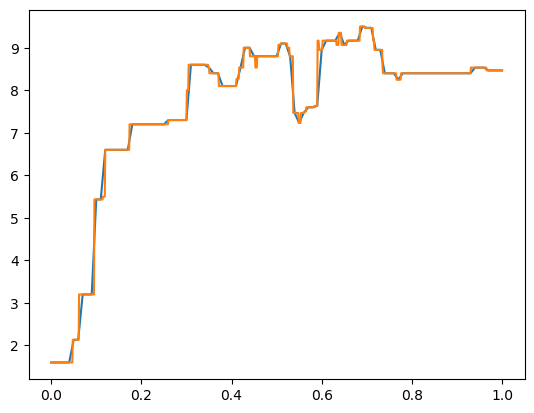

In [127]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, 1, 101), 
        pipe_adabr_v4.predict(get_pct_dists(100)*50))
ax.plot(np.linspace(0, 1, 1001), 
         pipe_adabr_v4.predict(get_pct_dists(1000)*50))
plt.show()

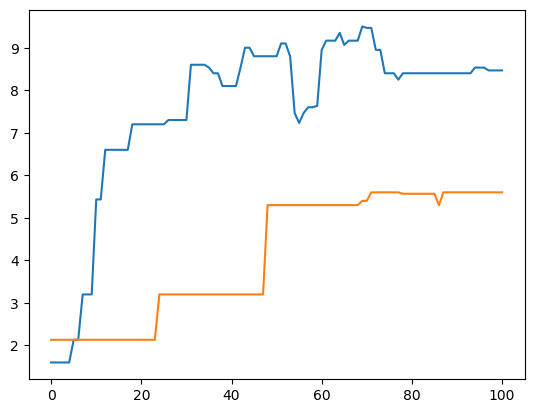

In [120]:
fig, ax = plt.subplots()
ax.plot(pipe_adabr_v4.predict(pct_dists*50))
ax.plot(pipe_adabr_v4.predict(pct_dists*10))
plt.show()

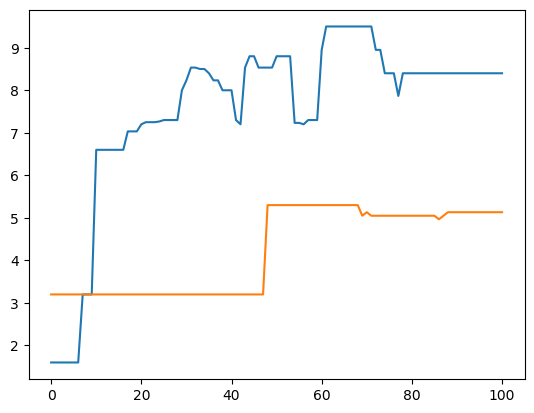

In [119]:
fig, ax = plt.subplots()
ax.plot(pipe_adabr_v3.predict(pct_dists*50))
ax.plot(pipe_adabr_v3.predict(pct_dists*10))
plt.show()

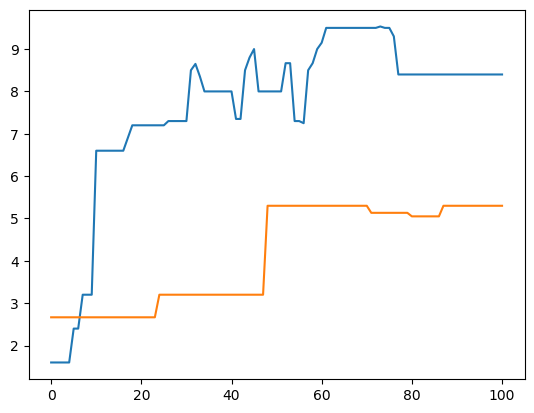

In [94]:
fig, ax = plt.subplots()
ax.plot(pipe_adabr_v2.predict(pct_dists*50))
ax.plot(pipe_adabr_v2.predict(pct_dists*10))
plt.show()


In [76]:
train_df["radio"].max()

49.4

In [77]:
train_df["radio"].min()

0.0

In [78]:
train_df["TV"].min()

0.7

In [ ]:
pipe_lnr_ransac.predict(get_synthetic_data("TV"))

In [46]:
pipe_lnr_ransac = pipe_lnr_ransac.fit(train_X, train_y)

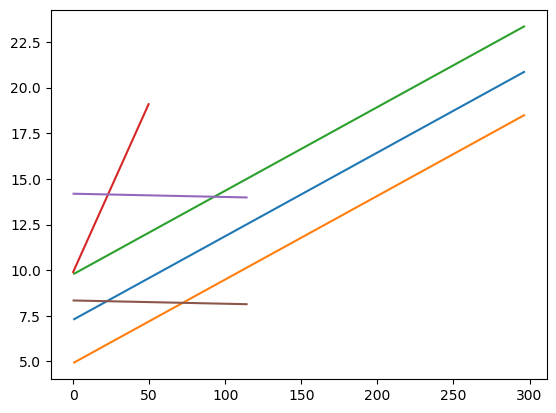

In [49]:
fig, ax = plt.subplots()
ax.plot(full_array("TV"), 
        pipe_lnr_ransac.predict(get_synthetic_data("TV")))
ax.plot(full_array("TV"), 
        pipe_lnr_ransac.predict(
            get_synthetic_data("TV", radio_q=0.25, newspaper_q=0.25)))
ax.plot(full_array("TV"), 
        pipe_lnr_ransac.predict(
            get_synthetic_data("TV", radio_q=0.75, newspaper_q=0.75)))
ax.plot(full_array("radio"), 
        pipe_lnr_ransac.predict(get_synthetic_data("radio")))
ax.plot(full_array("newspaper"), 
        pipe_lnr_ransac.predict(get_synthetic_data("newspaper")))
ax.plot(full_array("newspaper"), 
        pipe_lnr_ransac.predict(
            get_synthetic_data("newspaper", tv_q=0.25, radio_q=0.25)))
plt.show()

In [101]:
get_synthetic_data("TV")

array([[  0.7       ,  22.9       ,  25.75      ],
       [  3.68686869,  22.9       ,  25.75      ],
       [  6.67373737,  22.9       ,  25.75      ],
       [  9.66060606,  22.9       ,  25.75      ],
       [ 12.64747475,  22.9       ,  25.75      ],
       [ 15.63434343,  22.9       ,  25.75      ],
       [ 18.62121212,  22.9       ,  25.75      ],
       [ 21.60808081,  22.9       ,  25.75      ],
       [ 24.59494949,  22.9       ,  25.75      ],
       [ 27.58181818,  22.9       ,  25.75      ],
       [ 30.56868687,  22.9       ,  25.75      ],
       [ 33.55555556,  22.9       ,  25.75      ],
       [ 36.54242424,  22.9       ,  25.75      ],
       [ 39.52929293,  22.9       ,  25.75      ],
       [ 42.51616162,  22.9       ,  25.75      ],
       [ 45.5030303 ,  22.9       ,  25.75      ],
       [ 48.48989899,  22.9       ,  25.75      ],
       [ 51.47676768,  22.9       ,  25.75      ],
       [ 54.46363636,  22.9       ,  25.75      ],
       [ 57.45050505,  22.9    

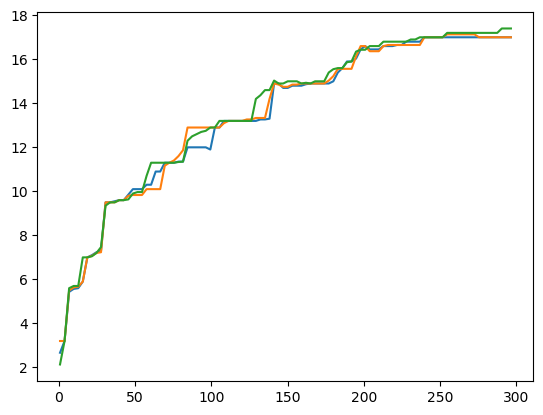

In [118]:
fig, ax = plt.subplots()

ax.plot(full_array("TV"), 
        pipe_adabr_v2.predict(get_synthetic_data("TV")))
ax.plot(full_array("TV"), 
        pipe_adabr_v3.predict(get_synthetic_data("TV")))
ax.plot(full_array("TV"), 
        pipe_adabr_v4.predict(get_synthetic_data("TV")))
plt.show()

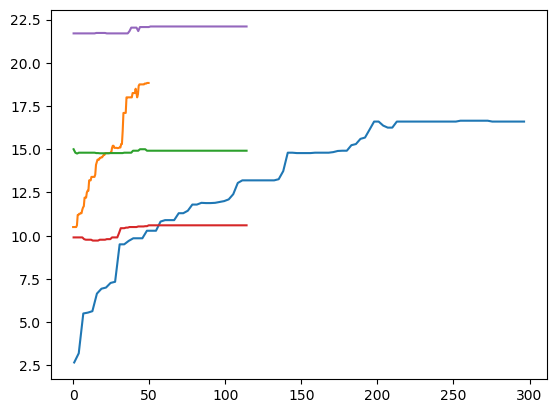

In [51]:
fig, ax = plt.subplots()

ax.plot(full_array("TV"), adabr_v2.predict(get_synthetic_data("TV")))
ax.plot(full_array("radio"), adabr_v2.predict(get_synthetic_data("radio")))
ax.plot(full_array("newspaper"), adabr_v2.predict(get_synthetic_data("newspaper")))
ax.plot(full_array("newspaper"), 
        adabr_v2.predict(
            get_synthetic_data("newspaper", tv_q=0.25, radio_q=0.25)))
ax.plot(full_array("newspaper"), 
        adabr_v2.predict(
            get_synthetic_data("newspaper", tv_q=0.75, radio_q=0.75)))
plt.show()

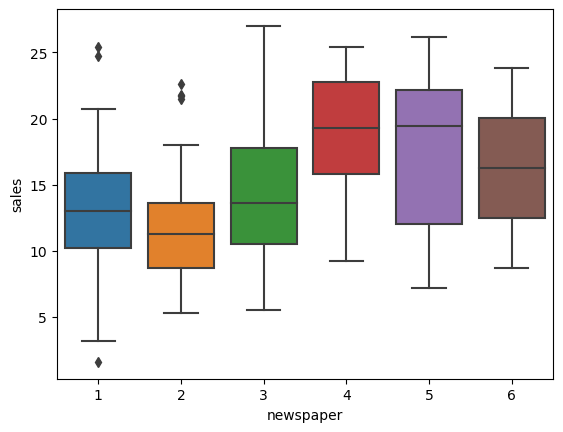

In [61]:
sns.boxplot(x=pd.cut(train_df["newspaper"], bins=6, labels=[1, 2, 3, 4, 5, 6]), 
            y=train_df["sales"])

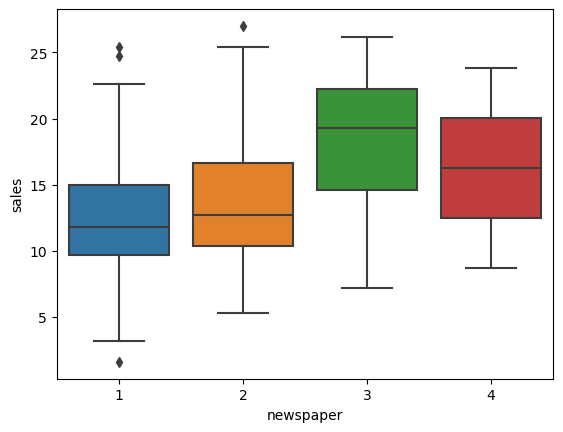

In [57]:
sns.boxplot(x=pd.cut(train_df["newspaper"], bins=4, labels=[1, 2, 3, 4]), 
            y=train_df["sales"])

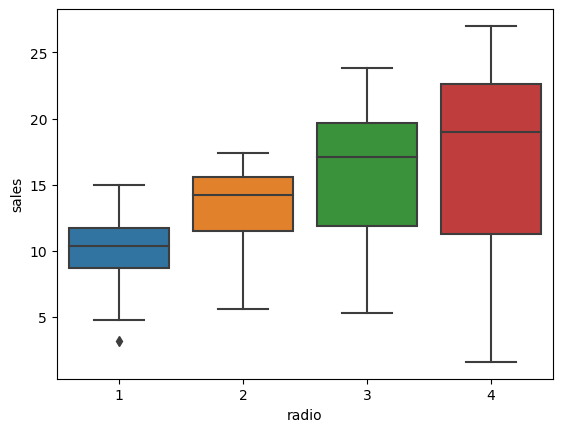

In [58]:
sns.boxplot(x=pd.cut(train_df["radio"], bins=4, labels=[1, 2, 3, 4]), 
            y=train_df["sales"])

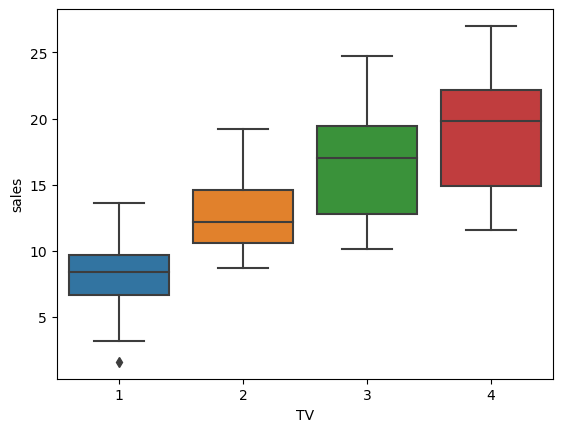

In [60]:
sns.boxplot(x=pd.cut(train_df["TV"], bins=4, labels=[1, 2, 3, 4]), 
            y=train_df["sales"])

In [115]:
gs_dtr_v2 = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=1), 
    param_grid=dtr_params, 
    scoring="r2", return_train_score=True, cv=5,
    n_jobs=-1, iid=True)
gs_dtr_v2 = gs_dtr_v2.fit(train_X[:, :2], train_y)
summarize_gs(gs_dtr_v2)

Best Parameters: {'max_depth': 10, 'min_samples_split': 4}
Best Score: 0.955 +/- 0.014


In [116]:
dtr_v2 = DecisionTreeRegressor(
    random_state=1).set_params(**gs_dtr_v2.best_params_)

In [118]:
evaluate_model(dtr_v2, X_train=train_X[:, :2], X_test=test_X[:, :2])

Training Set Score:  0.997
Test Set Score:      0.972


In [120]:
adabr_v3 = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(
        max_depth=10, min_samples_split=4),
    random_state=1)

In [121]:
evaluate_model(adabr_v3, X_train=train_X[:, :2], X_test=test_X[:, :2])

Training Set Score:  0.999
Test Set Score:      0.981


In [122]:
from mpl_toolkits.mplot3d import Axes3D

In [150]:
def get_z(x, y):
    
    #z = adabr_v3.predict(np.array([x, y]).reshape(1, -1))
    #z = adabr_v3.predict(np.array([x, y]).reshape(1, -1))
    z_rows = [adabr_v3.predict(
        np.vstack((X_mesh[i], Y_mesh[i])).transpose()) 
              for i in range(x.shape[0])]
    z = np.vstack(z_rows)
    return z

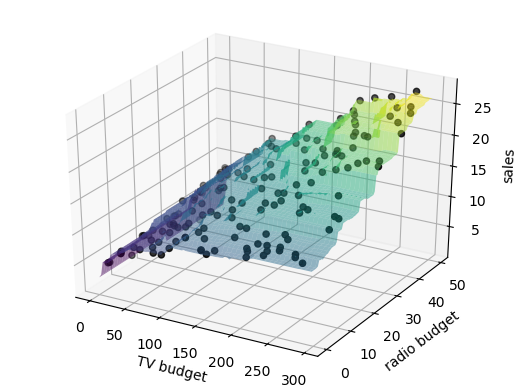

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X_mesh, Y_mesh = np.meshgrid(full_array("TV"), full_array("radio"))
Z = get_z(X_mesh, Y_mesh)
#ax.plot_surface(train_df["TV"], train_df["radio"], Z)
ax.plot_surface(X_mesh, Y_mesh, Z, cmap="viridis", alpha=0.5)

ax.scatter(train_df["TV"], train_df["radio"], train_df["sales"], color="black")
ax.set_xlabel("TV budget")
ax.set_ylabel("radio budget")
ax.set_zlabel("sales")

plt.show()

# Task 2: Recommend New Budget Allocations

## Description of Task and Market Constraints

**The company is going to run a promotion in the same market for a very similar product, and would like recommendations for how to distribute its advertising budget for each market amongst the three channels.**

No data is available regarding the effect (if any) the previous marketing campaign will have on the new marketing campaign, and thus recommendations should be based on the results of the previous campaign.

The total advertising budget for each market will remain the same.

### Market Constraints

Due to market conditions, the following restraints apply:
1. No more than 96% of the total advertising budget for a market may be allocated towards TV. TV budget must not exceed 296.4 thousand USD. 
2. No more than 81% of the total advertising budget for a market may be allocated towards radio. Radio budget must not exceed 49.6 thousand USD. 
2. No more than 66% of the total advertising budget for a market may be allocated towards newspaper. Newspaper budget must not exceed 114.0 thousand USD. 

&nbsp;

## Find Best Budget Allocation by Total Budget

Note: As the predictive power of the AdaBoost Regressor was so high (r2=0.975 for test set), it is highly unlikely that individual market characteristics had a significant impact on sales.

total_budget = TV + radio + newspaper <br>
total_budget = (a * total_budget) + (b * total_budget) + (c * total_budget) <br>
1 = a + b + c
<br>
<br>
0 <= a <= .96 <br> 0 <= (a * total_budget) <= 296.4
<br>
<br>
0 <= b <= .81 <br> 0 <= (b * total_budget) <= 49.6
<br>
<br>
0 <= c <= .66 <br> 0 <= (c * total_budget) <= 114.0

In [ ]:
def find_best_budget2(model, total_budget):
    # get possible values of a, b, and c
    a_max = min([.96, 296.4/total_budget])
    b_max = min([.81, 49.6/total_budget])
    
    #a_min = 1 - b_max
    a_poss = np.linspace(0, a_max, 
                         int(((a_max-a_min)/0.01) + 0.05))
    budget_poss = []
    for a_val in a_poss:
        #b_min = 1 - a_val
        b_val_max = min([b_max, 1-a_val])
        n_vals = max([int((b_val_max/0.01) + 0.05), 1])
        b_poss = np.linspace(0, b_val_max, n_vals)
        budget_poss.append(list(itertools.product([a_val], b_poss)))
    ab_poss = [[a_val, min(1-a_val, b_max)] for a_val in a_poss]
    ab_poss = np.array(ab_poss)
    # predict sales
    budgets = ab_poss * total_budget
    pred_sales = model.predict(budgets)
    best_budget_allocation = budgets[pred_sales.argmax()]
    best_budget_allocation = np.append(
        best_budget_allocation, pred_sales.max())
    return best_budget_allocation


Contribution margin is computed as the selling price per unit, minus the variable cost per unit.

In [ ]:
def optimize_budget(model, total_budget, margin):
    """
    margin : float
        contribution margin before accounting for advertising costs
    """
    # get possible values of a, b, and c
    max_pct_tv = min([.96, 296.4/total_budget])
    max_pct_radio = min([.81, 49.6/total_budget])
    
    possible_budgets = []
    tv_pcts = np.linspace(0, max_pct_tv, int((max_pct_tv/0.01) + 0.05))
    for pct_tv in tv_pcts:
        pct_remaining = min([max_pct_radio, 1-pct_tv])
        n_vals = max([int((pct_remaining/0.01) + 0.05), 1])
        radio_pcts = np.linspace(0, pct_remaining, n_vals)
        possible_budgets.append(list(itertools.product([pct_tv], radio_pcts)))
    possible_budgets = [
        [budget_pct[0], budget_pct[1], 1-sum(budget_pct)] 
        for sublist in possible_budgets for budget_pct in sublist]
    possible_budgets = np.array(possible_budgets[:, :2])
    # predict sales
    budgets = possible_budgets * total_budget
    pred_sales = model.predict(budgets)
    # predict profit
    pred_profit = pred_sales * margin
    advertising_costs = budgets[:, :2].sum(axis=1)
    remaining_budget = budgets[:, 2]
    pred_profit = pred_profit - advertising_costs + remaining_budget
    best_budget_allocation = np.append(
        budgets[pred_profit.argmax()], 
        pred_sales[pred_profit.argmax()], pred_profit.max())
    return best_budget_allocation
################################################################################

In [43]:
def find_best_budget(model, total_budget):
    # get possible values of a, b, and c
    a_max = min([.96, 296.4/total_budget])
    b_max = min([.81, 49.6/total_budget])
    c_max = min([.66, 114.0/total_budget])
    
    a_min = max([0, 1 - (b_max + c_max)])
    a_poss = np.linspace(a_min, a_max, 
                         int(((a_max-a_min)/0.01) + 0.05))
    abc_poss = []
    for a_val in a_poss:
        b_min = max([0, 1 - (a_val + c_max)])
        b_val_max = min([b_max, 1-a_val])
        n_vals = max([int(((b_val_max-b_min)/0.01) + 0.05), 1])
        b_poss = np.linspace(b_min, b_val_max, n_vals)
        abc_poss.append(list(itertools.product([a_val], b_poss)))
    abc_poss = [[ab[0], ab[1], 1-sum(ab)] 
                for sublist in abc_poss for ab in sublist]
    abc_poss = np.array(abc_poss)
    # predict sales
    budgets = abc_poss * total_budget
    pred_sales = model.predict(budgets)
    best_budget_allocation = budgets[pred_sales.argmax()]
    best_budget_allocation = np.append(
        best_budget_allocation, pred_sales.max())
    return best_budget_allocation


In [44]:
def get_budget_allocation_df(model):
    budget_alloc_dict = {
        total_budg: find_best_budget(model, total_budg) 
        for total_budg in range(10, 440)}
    
    best_budgets_df = pd.DataFrame.from_dict(
        budget_alloc_dict, orient="index", 
        columns=["TV", "radio", "newspaper", "sales"])
    best_budgets_df = best_budgets_df.reset_index().rename(
        columns={"index": "total_budget"})
    
    return best_budgets_df

## Visualize Recommendations

In [45]:
df["pct TV"] = df["TV"]/df["total_budget"]
df["pct radio"] = df["radio"]/df["total_budget"]
df["pct newspaper"] = df["newspaper"]/df["total_budget"]

In [46]:
lnr_budget = get_budget_allocation_df(pipe_ln_reg)
lnr_r_budget = get_budget_allocation_df(pipe_lnr_ransac)
dtr_budget = get_budget_allocation_df(dtr)
adabr_budget = get_budget_allocation_df(adabr_v2)

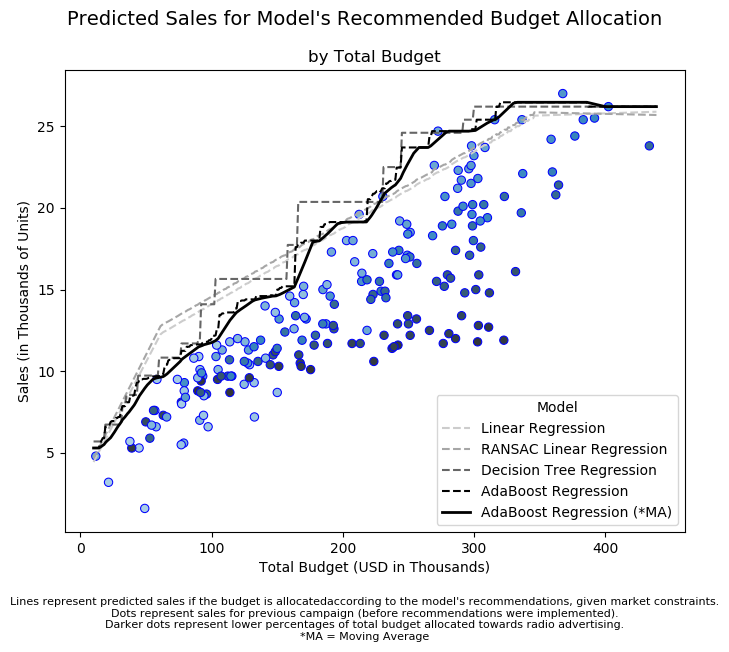

In [47]:
fig, my_ax = plt.subplots(figsize=(8, 6))

my_ax.plot(lnr_budget["total_budget"], lnr_budget["sales"], 
           color="#cccccc", linestyle="--", 
           label="Linear Regression")

my_ax.plot(lnr_r_budget["total_budget"], lnr_r_budget["sales"], 
           color="#a6a6a6", linestyle="--", 
           label="RANSAC Linear Regression")

my_ax.plot(dtr_budget["total_budget"], dtr_budget["sales"], 
           color="#666666", linestyle="--", 
           label="Decision Tree Regression")

my_ax.plot(adabr_budget["total_budget"], adabr_budget["sales"], 
           color="black", linestyle="--", 
           label="AdaBoost Regression")

my_ax.plot(adabr_budget["total_budget"], 
           adabr_budget["sales"].rolling(14, min_periods=1).mean(), 
           color="black", linewidth=2, 
           label="AdaBoost Regression (*MA)")

sns.scatterplot(df["total_budget"], df["sales"], hue=df["pct radio"], 
                ax=my_ax, palette=sns.color_palette("Blues_d", n_colors=200), 
                edgecolor="blue", legend=False)

fig.suptitle("Predicted Sales for Model's Recommended Budget Allocation", fontsize=14)
my_ax.set_title(
    "by Total Budget")

my_ax.set_xlabel("Total Budget (USD in Thousands)")
my_ax.set_ylabel("Sales (in Thousands of Units)")

plt.legend(title="Model")
foot_note1 = "Lines represent predicted sales if the budget is allocated"\
"according to the model's recommendations, given market constraints."
foot_note2 = "Dots represent sales for previous campaign "\
"(before recommendations were implemented)."
foot_note3 = "Darker dots "\
"represent lower percentages of total budget allocated towards radio advertising."
foot_note4 = "*MA = Moving Average"

foot_note = "\n".join([foot_note1, foot_note2, foot_note3, foot_note4])
plt.figtext(0.5, -0.07, foot_note, horizontalalignment='center', fontsize=8)
plt.show()

In [48]:
def plot_recommendations(my_ax, var_name):
    my_ax.plot(adabr_budget["total_budget"], 
               adabr_budget[var_name].rolling(14, min_periods=1).mean(), 
               color="black", linewidth=2, 
               label="AdaBoost Regression (*MA)")
    
    sns.scatterplot(df["total_budget"], df[var_name], ax=my_ax)
    
    my_ax.set_xlabel("Total Budget (USD in Thousands)")
    my_ax.set_ylabel(var_name + " budget")
    my_ax.legend_.remove()
    return my_ax



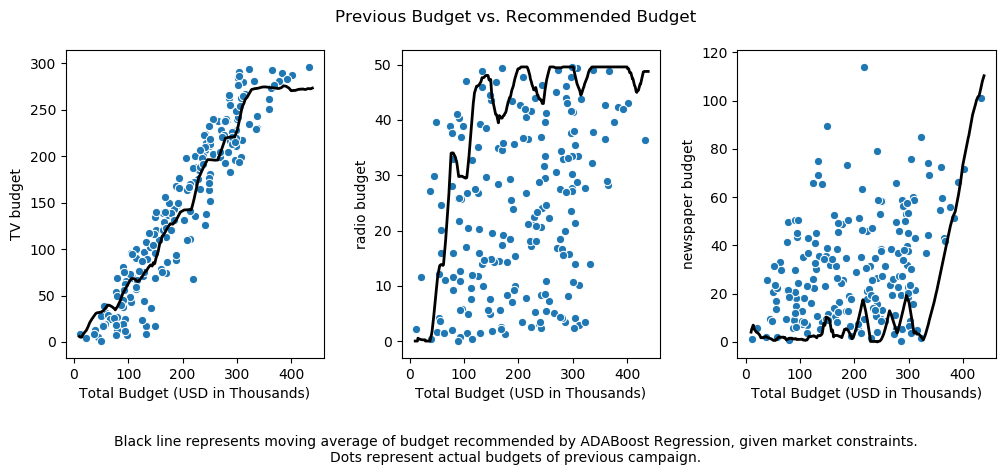

In [49]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
plot_recommendations(axes[0], "TV")
plot_recommendations(axes[1], "radio")
plot_recommendations(axes[2], "newspaper")
plt.subplots_adjust(wspace=.3)
plt.suptitle("Previous Budget vs. Recommended Budget")
foot_note = "Black line represents moving average of "\
"budget recommended by ADABoost Regression, given market constraints.\n"\
"Dots represent actual budgets of previous campaign."
plt.figtext(0.5, -0.15, foot_note, horizontalalignment='center')

plt.show()


## Describe Projected Increase in Sales

In [53]:
df["suggestions"] = df["total_budget"].apply(
    lambda x: find_best_budget(adabr_v2, x))

In [54]:
df["rec_TV"] = df["suggestions"].apply(lambda x: x[0])
df["rec_radio"] = df["suggestions"].apply(lambda x: x[1])
df["rec_newspaper"] = df["suggestions"].apply(lambda x: x[2])
df["projected_sales"] = df["suggestions"].apply(lambda x: x[3])


In [55]:
df = df.drop(columns="suggestions")

In [56]:
df.head()

,TV,radio,newspaper,total_budget,sales,pct TV,pct radio,pct newspaper,rec_TV,rec_radio,rec_newspaper,projected_sales
0,230.1,37.8,69.2,337.1,22.1,0.682587,0.112133,0.205280,275.331429,49.600000,12.168571,26.466667
1,44.5,39.3,45.1,128.9,10.4,0.345229,0.304888,0.349884,78.154105,48.259459,2.486435,14.400000
2,17.2,45.9,69.3,132.4,9.3,0.129909,0.346677,0.523414,77.600337,48.222222,6.577441,14.400000
3,151.5,41.3,58.5,251.3,18.5,0.602865,0.164345,0.232789,195.183600,49.600000,6.516400,23.700000
4,180.8,10.8,58.4,250.0,12.9,0.723200,0.043200,0.233600,196.480000,49.600000,3.920000,23.700000


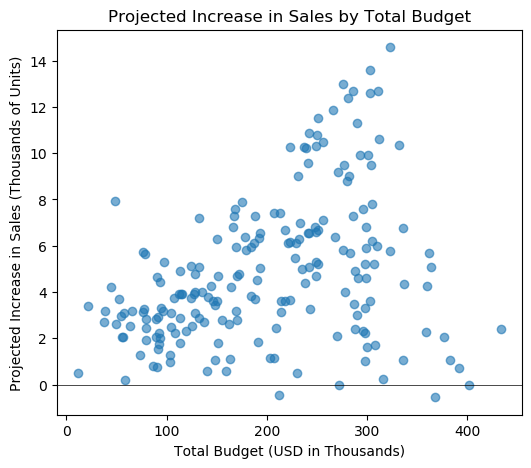

In [57]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(df["total_budget"], df["projected_sales"]-df["sales"], 
            alpha=0.6)
ax.axhline(color="black", linewidth=0.5)
ax.set_title("Projected Increase in Sales by Total Budget")
ax.set_xlabel("Total Budget (USD in Thousands)")
ax.set_ylabel("Projected Increase in Sales (Thousands of Units)")
plt.show()

Generally, if the company follows budget allocation recommendations, the increase in sales will be greater in markets with larger total advertising budgets. However, the increase will be smaller for markets with budgets over 350k USD, at which point market conditions will lead to diminished returns.

In [58]:
total_prev_sales = df["sales"].sum()
total_projected_sales = df["projected_sales"].sum()
improvement = total_projected_sales-total_prev_sales
print(total_prev_sales)
print(total_projected_sales.round(1))
print(improvement.round(1))
print((improvement/total_prev_sales).round(3))


2804.5
3776.1
971.6
0.346


## Results

Implementing the recommendation in advertising budget allocation would lead total sales across all markets to increase from 2,804,000 units per campaign to a projected 3,778,100 units per campaign. This increase of 971,600 units represents a **34.6% increase in sales!**

<hr>